<h1> <b>EDA</b> </h1>

In [2]:
#Librerias relevantes
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
from unidecode import unidecode

In [4]:
warnings.filterwarnings('ignore') #Ignora mensajes de advertencia que pueden distraer

<small>
<style>
.column {
  float: left;
  width: 50%;
}
.row:after {
  content: "";
  display: table;
  clear: both;
}
</style>
<h3>paletas de colores:</h3>
<div class="row">
  <div class="column">
  
**Azules analogos:**
* **#0452E9** [complementario a #e99b04]
* #04C5E9 (claro)
* #2804E9 (violáceo)</div>
  <div class="column">

**Amarillos analogos:**
* **#e99b04** [complementario a #0452E9]
* #C5E904 (claro)
* #E92804 (rojizo)</div>
</div>
</small>

### ***Datos a trabajar***

El dataset de interes es ***Internet.xlsx*** un archivo Excel de 15 hojas, con datos relacionados al flujo de datos de internet a lo largo del país

In [5]:
df_l = []
for i in range(15):
    df_l.append(pd.read_excel("./datasets/Internet.xlsx", i))

#### Empezamos con la hoja **[ Acc_vel_loc_sinrangos ]**

In [6]:
df_l[0].head(1)

,Partido,Localidad,link Indec,Velocidad (Mbps),Provincia,Accesos
0,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,0.0,1.0


Vemos que los nombres de las columnas no estan correctamente colocadas.
Se puede asumir que el orden correcto es: 
<h5><b><i>provincia - partido - localidad - link Indec - Velocidad - accesos</i></b></h5>

In [7]:
correction = {
    'Partido':'Provincia',
    'Localidad':'Partido',
    'link Indec':'Localidad',
    'Velocidad (Mbps)':'link Indec',
    'Provincia':'Velocidad (Mbps)'
}
acc_vel_loc : pd.DataFrame = df_l[0].rename(columns=correction)
acc_vel_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
Velocidad (Mbps),18864.0,66.866042,178.987138,0.0,3.0,10.0,30.0,1024.0
Accesos,18857.0,612.828499,6283.359677,-5582.0,3.0,26.0,180.0,576789.0


Se pueden identificar inconcistencias entre la cantidad de registros no nulos (count), el minimo de accesos encontrado (-5582 que es un valor negativo y por tanto imposible)
Para ello realizamos unas cuantas decisiones:
***
* ***Eliminar*** **duplicados** exactos (si hubiera)
* ***Eliminar*** aquellos registros con accesos **nulos, ceros o negativos**
* ***Descartar*** columnas sobre **localidad, partido y link Indec** de los datos
* ***Agrupar*** los datos según **provincia** y **velocidad**
***

In [8]:
acc_vel_loc.drop_duplicates(inplace=True)
acc_vel_loc = acc_vel_loc[acc_vel_loc['Accesos'].notna()][acc_vel_loc['Accesos'] > 0]
acc_vel_loc.drop(columns=['Partido', 'Localidad', 'link Indec'], inplace=True)

acc_vel_prov = acc_vel_loc.groupby(['Provincia', 'Velocidad (Mbps)'], as_index=False).agg({"Accesos":"sum"})

#? optenemos el promedio de velocidad según la provincia
acc_vel_prov['Velocidad (Mbps)'] = acc_vel_prov['Velocidad (Mbps)'] * acc_vel_prov['Accesos']

acc_vel_prov = acc_vel_prov.groupby('Provincia', as_index=False).agg({"Accesos":"sum", "Velocidad (Mbps)":"sum"})

acc_vel_prov['Velocidad (Mbps)'] = acc_vel_prov['Velocidad (Mbps)'] / acc_vel_prov['Accesos']

acc_vel_prov.describe().T

,count,mean,std,min,25%,50%,75%,max
Accesos,24.0,481796.25000,1.023700e+06,61409.000000,116260.500000,160575.500000,273763.250000,4.989380e+06
Velocidad (Mbps),24.0,84.28083,5.167471e+01,17.791244,48.949121,84.720524,101.559294,2.329202e+02


Ahora podemos analizar la velocidad de coneccion en cada provincia y la cantidad de accesos entre ellas

In [9]:
geojson_path = 'ar.json'
argentina_map = gpd.read_file(geojson_path)

In [10]:
argentina_map["name"] = argentina_map["name"].apply(lambda x: unidecode(x).upper()) # Lo llevamos a un formato de texto común
argentina_map["name"] = argentina_map["name"].str.replace("CIUDAD DE BUENOS AIRES","CABA") # Estandarizamos los nombres que difieren

In [11]:
argentina_map = argentina_map[["id", "name", "geometry"]].merge(acc_vel_prov, left_on='name', right_on='Provincia', how='left')

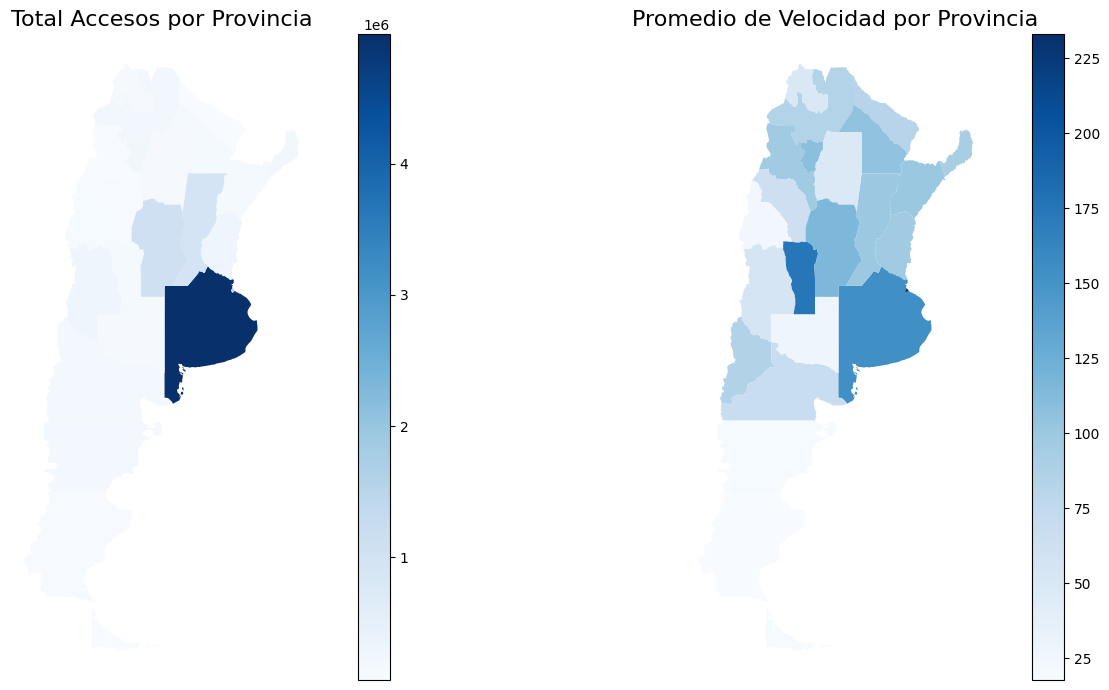

In [12]:
fig,  (ax, ax2) = plt.subplots(1, 2, figsize=(16, 7))
gpd.GeoDataFrame(argentina_map).plot(column='Accesos',cmap="Blues", legend=True, ax=ax)
ax.set_title('Total Accesos por Provincia', fontsize=16)
ax.axis('off')

gpd.GeoDataFrame(argentina_map).plot(column='Velocidad (Mbps)',cmap="Blues", legend=True, ax=ax2)
ax2.set_title('Promedio de Velocidad por Provincia', fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

Es visisble que los accesos registrados se encuentran mayoritariamente entre ***SANTA FE, CORDOBA, CABA y la provincia de BUENOS AIRES***
siendo esta ultima origen principal de loa accesos registrados, y esto parece reflejarse también de forma leve en cuanto a la **velocidad** del servicio

In [43]:
pd.DataFrame(argentina_map).drop(columns="Provincia", inplace=True, errors='ignore')
pd.DataFrame(argentina_map).to_csv("./datasets/map_prov_acc_vel.csv", index=False)

#### **[ Velocidad_sin_Rangos ]**

En relacion a la informacion previa podemos ver la evolucion de estos datos a lo largo del tiempo

In [14]:
df_l[1].describe().T

,count,mean,std,min,25%,50%,75%,max
Año,18884.0,2021.017104,1.919740,2017.0,2019.0,2021.0,2023.0,2024.0
Trimestre,18884.0,2.477653,1.126947,1.0,1.0,2.0,4.0,4.0
Velocidad,18874.0,96.171156,379.722905,0.0,4.0,12.3,50.1,10000.0
Accesos,18884.0,14123.280979,68563.873818,0.0,26.0,672.5,6114.0,1346370.0


Se puede observar que la columna **Velocidad** contiene algunos valores **nulos**,
y dado que queremos obtener informacion a partir de las velocidades podemos ignorar dichos registros

Nuevamente agrupamos el dataframe segun Año-Trimestre-Provincia, de forma en que tengamos el total de accesos y promedio de la velocidad

In [15]:
acc_vel_prov_timeline = pd.DataFrame(df_l[1]).dropna(subset=["Velocidad"])
acc_vel_prov_timeline = acc_vel_prov_timeline[acc_vel_prov_timeline['Accesos'].notna()][acc_vel_prov_timeline['Accesos'] > 0]
acc_vel_prov_timeline["Provincia"] = acc_vel_prov_timeline["Provincia"].apply(lambda x: unidecode(x).upper())
acc_vel_prov_timeline["Provincia"] = acc_vel_prov_timeline["Provincia"].str.replace("CAPITAL FEDERAL","CABA") # Estandarizamos los nombres que difieren

acc_vel_prov_timeline["Provincia"].value_counts().count()


24

In [16]:
#? optenemos el promedio de velocidad según la provincia y el periodod
acc_vel_prov_timeline['Velocidad'] = acc_vel_prov_timeline['Velocidad'] * acc_vel_prov_timeline['Accesos']

acc_vel_prov_timeline = acc_vel_prov_timeline.groupby(['Año', 'Trimestre','Provincia'], as_index=False).agg({"Accesos":"sum", "Velocidad": "sum"})

acc_vel_prov_timeline['Velocidad'] = acc_vel_prov_timeline['Velocidad'] / acc_vel_prov_timeline['Accesos']
acc_vel_prov_timeline.head(1)


,Año,Trimestre,Provincia,Accesos,Velocidad
0,2017,4,BUENOS AIRES,3188332,12.905339


A partir de esto podemos establecer una visualización de la adopcion de los servicios y la evolución en cuestión de velocidad a lo largo del tiempo con un filtro que nos permita elegir la provincia queremos analizar

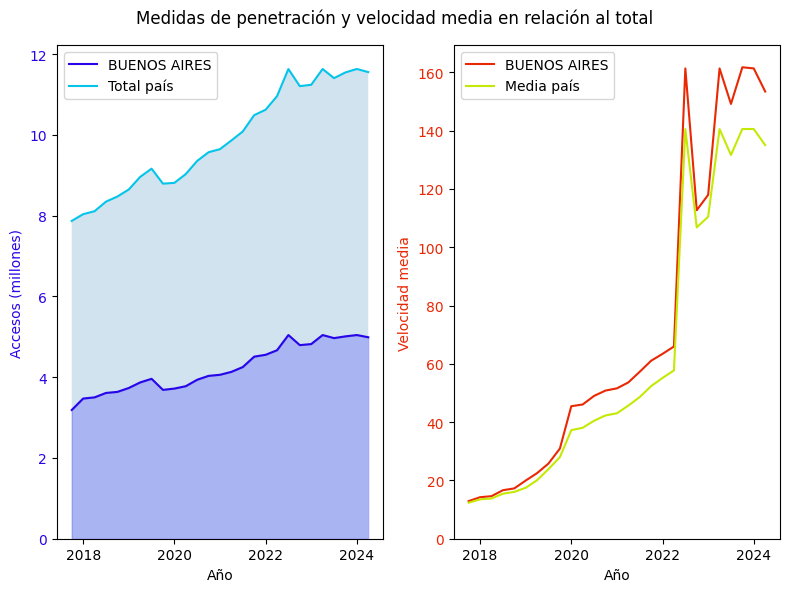

In [17]:
prov = "BUENOS AIRES"
target = acc_vel_prov_timeline[acc_vel_prov_timeline["Provincia"]==prov]

total = acc_vel_prov_timeline[["Año", "Trimestre", "Velocidad", "Accesos"]]
total["Velocidad"] = total["Velocidad"]*total["Accesos"]
total =total.groupby(['Año', 'Trimestre'], as_index=False).agg({"Accesos":"sum", "Velocidad": "sum"})
total["Velocidad"] = total["Velocidad"] / total["Accesos"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 6))

plt.suptitle("Medidas de penetración y velocidad media en relación al total")

sns.lineplot(x=target["Año"]+ (target["Trimestre"]-1)/4, y=target["Accesos"]/1_000_000, color="#2804E9", ax=ax1, label=prov)
sns.lineplot(x=total["Año"]+ (total["Trimestre"]-1)/4, y=total["Accesos"]/1_000_000, color="#04C5E9", ax=ax1, label="Total país")

ax1.set_xlabel("Año")
ax1.set_ylabel("Accesos (millones)", color="#2804E9")
ax1.fill_between((total["Año"]+ (total["Trimestre"]-1)/4).values, total["Accesos"].values/1_000_000, alpha=0.2)
ax1.fill_between((target["Año"]+ (target["Trimestre"]-1)/4).values, target["Accesos"].values/1_000_000, alpha=0.2, color="blue")
ax1.tick_params(axis='y', labelcolor="#2804E9")
ax1.set_ylim(bottom=0)

sns.lineplot(x=target["Año"]+ (target["Trimestre"]-1)/4, y=target["Velocidad"], color="#E92804", ax=ax2, label=prov)
sns.lineplot(x=total["Año"]+ (total["Trimestre"]-1)/4, y=total["Velocidad"], color="#C5E904", ax=ax2, label="Media país")

ax2.set_xlabel("Año")
ax2.set_ylabel("Velocidad media", color="#E92804")

ax2.tick_params(axis='y', labelcolor="#E92804")
ax2.set_ylim(bottom=0)
fig.tight_layout()

Se observan tendencias a nivel nacional, destacando el crecimiento de la cantidad de **accesos** a los servicios y la **velocidad** media ofrecida (que se estabilizan en los periodos recientes)

Text(0, 0.5, 'Velocidad media')

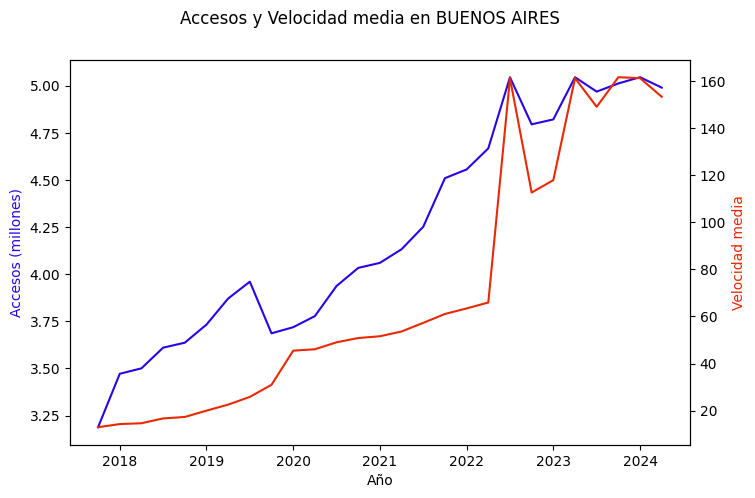

In [18]:

fig, ax1 = plt.subplots(1,1, figsize=(8, 5))
plt.suptitle(f"Accesos y Velocidad media en {prov}")
plt.xlabel("Año")
sns.lineplot(x=target["Año"]+ (target["Trimestre"]-1)/4, y=target["Accesos"]/1_000_000, color="#2804E9", ax=ax1)
ax1.set_ylabel("Accesos (millones)", color="#2804E9")
ax2=ax1.twinx()
sns.lineplot(x=target["Año"]+ (target["Trimestre"]-1)/4, y=target["Velocidad"], color="#E92804", ax=ax2)
ax2.set_ylabel("Velocidad media", color="#E92804")


Tambien se observa una relación en los periodos de los ultimos años entre la **velocidad media** y la **cantidad de accesos** registrados, decreciendo y creciendo de manera conjunta en la mayoria de las provincias, independientemente de la cantidad de habitantes en la provincia

In [40]:
pd.DataFrame(acc_vel_prov_timeline).to_csv("./datasets/acc_vel_prov_timeline.csv", index=False)

#### **[ Accesos_tecnologia_localidad , Totales accesos por tecnologias y accesos por tecnologias ]**

Nos es comveniente determinar la relación entre estos eventos y las tecnologias utilizadas

In [19]:
acc_tec_prov:pd.DataFrame = df_l[2].drop_duplicates()
acc_tec_prov.drop(columns=["Partido","Localidad","Link Indec"], inplace=True)
acc_tec_prov["Tecnologia"] = acc_tec_prov["Tecnologia"].apply(lambda x: unidecode(x).upper())
acc_tec_prov = acc_tec_prov.groupby(["Provincia","Tecnologia"], as_index=False).agg({"Accesos":"sum"})
acc_tec_prov.sort_values(by=["Provincia","Accesos"], inplace=True, ascending=[True,False])


Text(0, 0.5, 'Accesos (cientos de miles)')

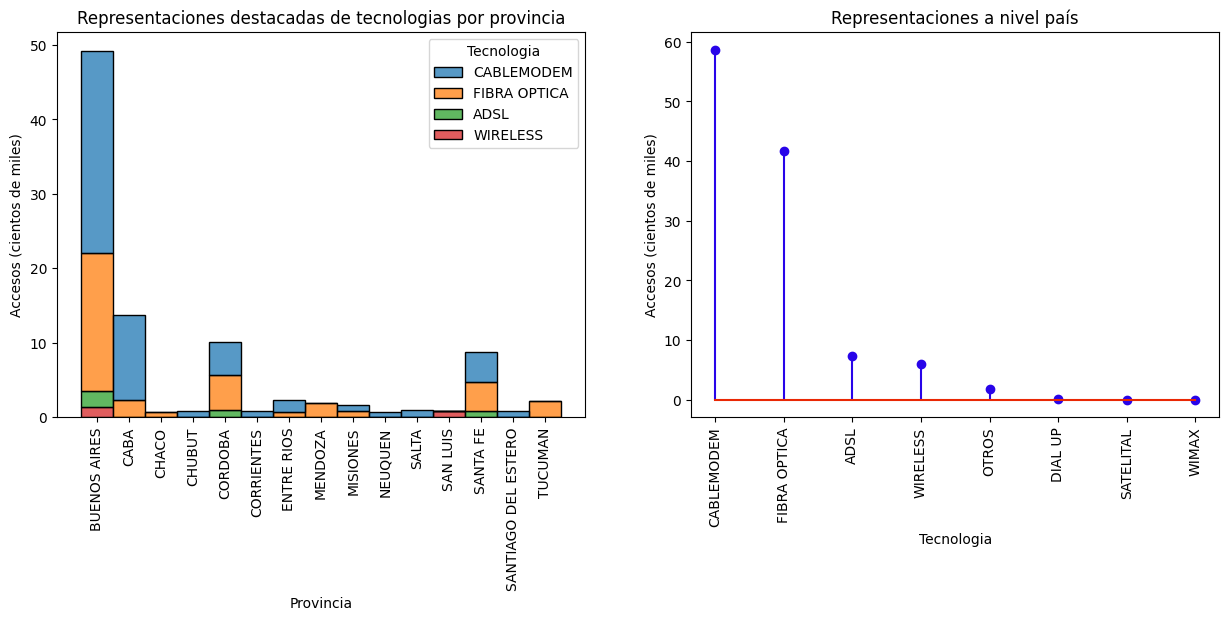

In [20]:
plt.figure(1, figsize=(15, 5))

ax1= plt.subplot(1,2,1)
plt.xticks(rotation=90)
plt.title("Representaciones destacadas de tecnologias por provincia")
sns.histplot(acc_tec_prov[acc_tec_prov["Accesos"]>acc_tec_prov["Accesos"].mean()], x='Provincia', hue='Tecnologia', weights=acc_tec_prov[acc_tec_prov["Accesos"]>acc_tec_prov["Accesos"].mean()]["Accesos"]/100000, multiple='stack', ax=ax1)
ax1.set_xlabel("Provincia")
ax1.set_ylabel("Accesos (cientos de miles)")

ax2= plt.subplot(1,2,2)
total = acc_tec_prov.groupby(["Tecnologia"], as_index=True).agg({"Accesos":"sum"}).sort_values("Accesos", ascending=False)
plt.xticks(rotation=90)
plt.title("Representaciones a nivel país")
plt.stem(total.index, total.values/100000, basefmt="#E92804", linefmt="#2804E9")
ax2.set_xlabel("Tecnologia")
ax2.set_ylabel("Accesos (cientos de miles)")

Notamos la importancia que tienen para la empresa la tecnologias **CABLEMODEM**, **FIBRA OPTICA**, **ADLS** (por cables de telefonia) y de conección **WIRELESS**, o inalambrica, en relación al resto de las tecnologias ofrecidas, siendo estas las mas antiguas y de menor calidad/velocidad de transmisión de datos

Esta relación se vé también con las columnas dedicadas en las hojas "Totales accesos por tecnologias" y "accesos por tecnologias"

In [21]:
acc_tec_prov_timeline = df_l[6].drop_duplicates()
acc_tec_tot_timeline = df_l[5].drop_duplicates().drop(columns="Periodo")

Si bien el dataframe a nivel nacional es consistente, a nivel provincial ocurre un problema con la incorporacion de datos en 2019, entre el 1er y 3er trimestre

In [22]:
print(acc_tec_prov_timeline[acc_tec_prov_timeline["Año"]=="*"]["Trimestre"].values[0])
acc_tec_prov_timeline[acc_tec_prov_timeline["Año"]=="2019 *"].head(1)

Los datos provinciales no coinciden a nivel nacional, ya que se rincorporó información que no contien apertuta a nivel geográfico.


,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
455,2019 *,3 *,Buenos Aires,1277249.0,2144956.0,425386.0,85572.0,27070.0,3960233.0


In [23]:
acc_tec_prov_timeline.dropna(subset=["Provincia"], inplace=True)
acc_tec_prov_timeline["Provincia"] = acc_tec_prov_timeline["Provincia"].apply(lambda x: unidecode(x).upper())
acc_tec_prov_timeline["Provincia"] = acc_tec_prov_timeline["Provincia"].str.replace("CAPITAL FEDERAL","CABA") # Estandarizamos los nombres que difieren


In [24]:
acc_tec_prov_timeline=acc_tec_prov_timeline[acc_tec_prov_timeline["Año"]!="*"]
acc_tec_prov_timeline["Año"] = acc_tec_prov_timeline["Año"].apply(lambda x: int(x.rstrip(" *")) if type(x)==str else x)
acc_tec_prov_timeline["Trimestre"]=acc_tec_prov_timeline["Trimestre"].apply(lambda x: int(x.rstrip(" *")) if type(x)==str else x)

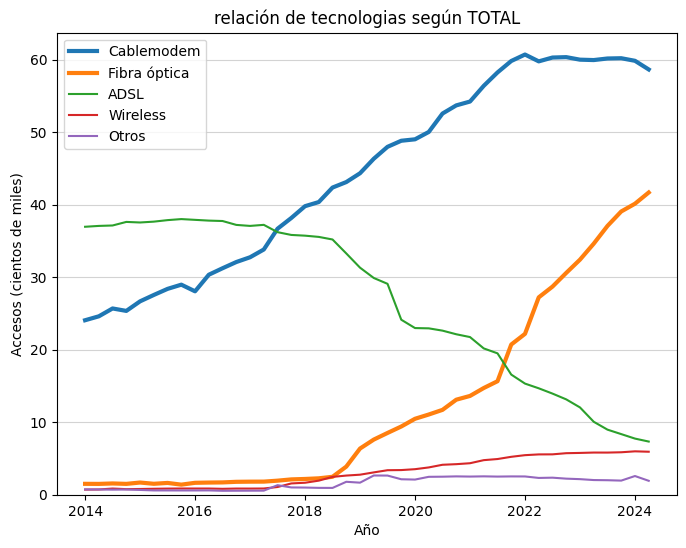

In [25]:
prov = "TOTAL"
if prov == "TOTAL": #? utilizado como filtro para simplificar graficas
    target = acc_tec_tot_timeline.copy()
else:
    target = acc_tec_prov_timeline[acc_tec_prov_timeline["Provincia"]==prov] #? prov es aquella usada previamente


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
target["Total"] = target[["ADSL","Cablemodem","Fibra óptica","Wireless","Otros"]].sum(axis=1)
target["indexdate"] = target["Año"]+(target["Trimestre"]-1)/4
target_scaled= target[["Cablemodem","Fibra óptica","ADSL","Wireless","Otros"]]/100000
target_scaled["indexdate"] = target["indexdate"]
target_scaled.plot(x="indexdate", y=["Cablemodem","Fibra óptica"], linewidth=3, ax=ax1)
target_scaled.plot(x="indexdate", y=["ADSL","Wireless","Otros"], ax=ax1)

plt.title(f"relación de tecnologias según {prov}")

plt.ticklabel_format(style="plain")
plt.xlabel("Año")
plt.ylabel("Accesos (cientos de miles)")

ax1.set_ylim(bottom=0)
plt.grid(True, axis="y", color="lightgrey")

Se vé la tendencia a lo largo del país a implementar las tecnologías de **CABLEMODEM** y **FIBRA OPTICA** de forma *creciente*, mientras se dejan de implementar aquellas más antiguas, la figura previa puede complementar lo visto en la figura ***"Medidas de penetración y velocidad media en relación al total"***, que nos permite identificar una relación no solo entre la velocidad de los servicios con la cantidad de accesos, sino también con tipos concretos de tecnologias.

Esto tambien guarda un sentido logico, dado que a mayor implementación de esta tecnologias populares, mayor se vuelve el promedio de velocidad de la región 

A partir de estos insights surge el primer ***KPI*** a tomar en cuenta
<div style="text-align: center;"> <b><i>Incrementar en un 1,5% el uso de tecnologías de alta velocidad en comparación al trimestre anterior</b></i></div>

A<small>n</small> = Suma de accesos entre CABLEMODEM y FIBRA OPTICA del trimestre actual<br/>
A<small>o</small> = Suma de accesos entre CABLEMODEM y FIBRA OPTICA del trimestre previo<br/>
T<small>n</small> = Total de accesos en el trimestre actual<br/>
T<small>o</small> = Total de accesos en el trimestre previo<br/>

KPI=(( A<small>n</small>/T<small>n</small> ) - ( A<small>o</small>/T<small>o</small> )) * 100

**De modo que este valor debe de aproximarse al valor objetivo para poder cumplirse**

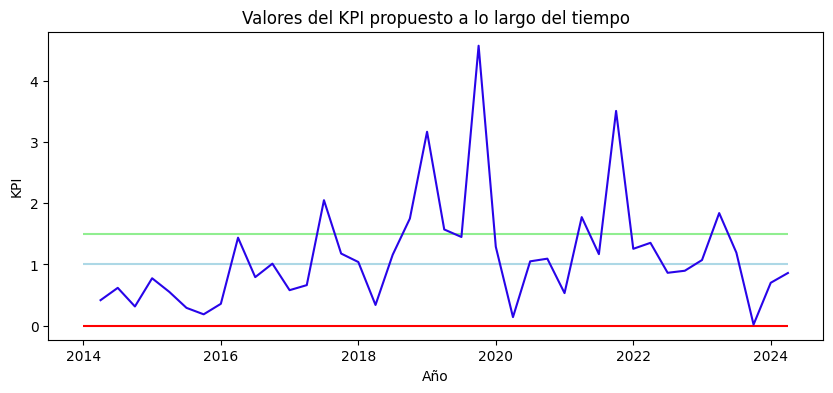

In [26]:
kpi1_base= acc_tec_tot_timeline.copy()

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))
kpi1_base["indexdate"] = kpi1_base["Año"]+(kpi1_base["Trimestre"]-1)/4
kpi1_base["Total"] = kpi1_base[["ADSL","Cablemodem","Fibra óptica","Wireless","Otros"]].sum(axis=1)
kpi1_base["CMFO %"] = kpi1_base[["Cablemodem","Fibra óptica"]].sum(axis=1)/kpi1_base["Total"]*100
kpi1_base.drop(columns= ["ADSL","Cablemodem","Fibra óptica","Wireless","Otros","Año","Trimestre"], inplace=True)
#? sns.lineplot(target, x=target["Año"]+(target["Trimestre"]-1)/4, y=)
kpi1_base["difCMFO %"] = pd.DataFrame(kpi1_base["CMFO %"]).sort_values("CMFO %").diff(periods=1,axis=0)

plt.title(f"Valores del KPI propuesto a lo largo del tiempo")

plt.ticklabel_format(style="plain")
plt.xlabel("Año")
plt.ylabel("KPI")
plt.hlines((0,1,1.5), kpi1_base["indexdate"].min(),kpi1_base["indexdate"].max(), colors=("red", "lightblue", "lightgreen"))
plt.plot(kpi1_base["indexdate"].values, kpi1_base["difCMFO %"], c="#2804E9")


En relación a la tendencia historica del valor podemos concluir un 1,5 como valor objetivo razonable, siendo 0 en este valor un indicador de crecimiento nulo en la aplicación de las tecnologias de CableModem y FibraOptica

In [53]:
pd.DataFrame(acc_tec_tot_timeline).to_csv("./datasets/acc_tec_tot_timeline.csv", index=False)
pd.DataFrame(acc_tec_prov_timeline).to_csv("./datasets/acc_tec_prov_timeline.csv", index=False)

pd.DataFrame(acc_tec_prov).to_csv("./datasets/acc_tec_prov.csv", index=False)

#### **[ Penetración-poblacion , Penetracion-hogares y penetracion-totales ]**

In [27]:
acc_hab = df_l[7].drop_duplicates() #población
acc_hog = df_l[8].drop_duplicates() #hogares
acc_tot_hog_hab = df_l[9].drop_duplicates() #a nivel nacional

In [28]:
acc_hog.dropna(subset=["Provincia"], inplace=True)
acc_hab.dropna(subset=["Provincia"], inplace=True)
# Estandarizamos la escritura a mayuscula sin acentos
acc_hog["Provincia"] = acc_hog["Provincia"].apply(lambda x: unidecode(x).upper())
acc_hab["Provincia"] = acc_hab["Provincia"].apply(lambda x: unidecode(x).upper())
# Estandarizamos los nombres que difieren
acc_hog["Provincia"] = acc_hog["Provincia"].str.replace("CAPITAL FEDERAL","CABA") 
acc_hab["Provincia"] = acc_hab["Provincia"].str.replace("CAPITAL FEDERAL","CABA")

Queremos unificar estos dataframes en uno unico

In [46]:
acc_prov_hog_hab = pd.DataFrame(acc_hog).merge(acc_hab, on=["Año", "Trimestre", "Provincia"])

acc_prov_hog_hab.rename(columns={"Accesos por cada 100 hab":"Accesos por cada 100 habitantes"}, inplace=True)
acc_tot_hog_hab.drop(columns="Periodo", inplace=True)
acc_tot_hog_hab.rename(columns={"Accesos por cada 100 hab":"Accesos por cada 100 habitantes"}, inplace=True)


Ahora podemos graficar ambos dataframes según se desee filtrar por provincia o a nivel nacional

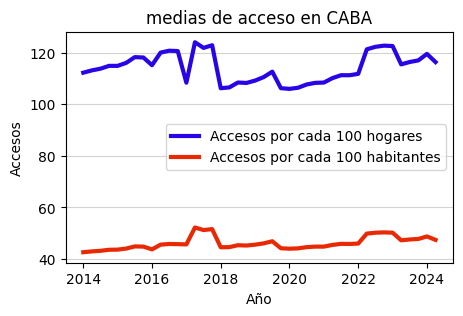

In [52]:
prov = "CABA"
hogares = 2 # Se visualizan cada 100 hogares (0), cada 100 habitantes(1), o ambos (2)

if prov == "TOTAL": #? utilizado como filtro para simplificar graficas
    target = acc_tot_hog_hab.copy()
else:
    target = acc_prov_hog_hab[acc_prov_hog_hab["Provincia"]==prov] #? prov es aquella usada previamente
columnas=['Accesos por cada 100 hogares','Accesos por cada 100 habitantes']
colors = ["#2804E9","#E92804"]
viz_column,viz_color=(columnas[hogares],colors[hogares]) if hogares<2 else (columnas,colors)
both = hogares==2

fig, ax1 = plt.subplots(1,1, figsize=(5, 3))
target["indexdate"] = target["Año"]+(target["Trimestre"]-1)/4
target.plot(x="indexdate", y=viz_column, linewidth=3, ax=ax1, legend=both, color=viz_color)

plt.title(f"medias de acceso en {prov}")

plt.ticklabel_format(style="plain")
plt.xlabel("Año")
if both:
    plt.ylabel("Accesos")
else:
    plt.ylabel(viz_column)

plt.grid(True, axis="y", color="lightgrey")

Es mediante estos dataframes que podemos responder al segundo **KPI** propuesto 

<div style="text-align: center;"> <b><i>Aumentar en un 2% el acceso al servicio de internet para el próximo trimestre, cada 100 hogares, por provincia.</b></i></div>

A<small>n</small> = Accesos cada 100 hogares del trimestre actual en la provincia analizada<br/>
A<small>o</small> = Accesos cada 100 hogares del trimestre previo en la provincia analizada<br/>

KPI=((A<small>n</small> − A<small>o</small>)/A<small>o</small>) ∗ 100

In [49]:
pd.DataFrame(acc_prov_hog_hab).to_csv("./datasets/acc_prov_hog_hab.csv", index=False)
pd.DataFrame(acc_tot_hog_hab).to_csv("./datasets/acc_tot_hog_hab.csv", index=False)